In [1]:
from Utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os.path


In [2]:
coupling_type = '1JHC'
XY_Data = pd.read_csv(f'{Config.INPUT_XY}/{coupling_type}.csv', index_col=0)

In [3]:
XY_Data.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,r_x_1,r_x_2,...,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
count,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.00000,709416.000000,709416.000000,709416.000000,...,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000
mean,2.571980,4.718922,5.776832,2.685567,3.561376,4.026453,4.10719,4.122326,-0.546450,-0.979225,...,2.603802,3.201349,2.708477,3.081578,2.742679,3.397891,2.879005,3.209599,2.881505,94.976153
std,2.623271,2.590104,1.326641,2.572154,2.778925,2.734745,2.73514,2.738560,0.003409,0.167632,...,0.910025,0.530468,0.472534,0.737463,0.950420,0.599315,0.557853,0.800406,0.986800,18.277237
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.623971,-1.741393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.600800
25%,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.00000,1.000000,-0.548073,-1.012368,...,1.562680,2.843148,2.399893,2.616609,2.146409,3.014524,2.518891,2.678212,2.232923,84.023000
50%,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,6.00000,6.000000,-0.547013,-0.896096,...,2.747965,3.086795,2.620761,2.993071,2.790644,3.302688,2.760554,3.082533,2.819318,88.223650
75%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,-0.545149,-0.878620,...,3.266232,3.451435,2.872551,3.570941,3.459018,3.659509,3.128873,3.801972,3.631753,100.735000
max,8.000000,8.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000,-0.530450,-0.788244,...,6.000680,9.967474,8.905101,8.536893,7.336814,11.029771,9.967474,9.593333,8.259678,204.880000


In [4]:
def get_filtered_errors(coupling_type):
    filterFile = f'{Config.INPUT_XY_FILTER}/{coupling_type}.csv'
    isFilter = os.path.exists(filterFile)
    if  not isFilter:
        dpOldErr = None
    else:
        dpOldErr = pd.read_csv(f'{Config.INPUT_XY_FILTER}/{coupling_type}.csv', index_col=0)
    return dpOldErr

In [5]:
def get_filtered_xy(dpOldErr):
    if dpOldErr is None:
        XY_Filtered = XY_Data
    else:    
        mask = XY_Data.index.isin(dpOldErr.index)
        mask = np.invert(mask)
        XY_Filtered = XY_Data.loc[mask]
        XY_Filtered.describe()
    return XY_Filtered

dpOldErr = get_filtered_errors(coupling_type)
XY_Filtered = get_filtered_xy(dpOldErr)

In [6]:
X_data, y_data = build_x_y_data(XY_Filtered)
#X_data, y_data
#X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=228)

In [7]:
%time 
X_train = X_data
X_val =  X_data
y_train = y_data
y_val = y_data
categorical_features = [col for col in X_train if col.startswith('atom_')]

#X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=228)
# to record eval results for plotting
model = LGBMRegressor(**Config.LGB_PARAMS, n_estimators=500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=1000,
         categorical_feature = categorical_features)

y_pred = model.predict(X_val)
print(mean_absolute_error(y_val, y_pred))
np.log(mean_absolute_error(y_val, y_pred))


Wall time: 0 ns


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 1.49197
[200]	training's l1: 1.28696
[300]	training's l1: 1.19093
[400]	training's l1: 1.1237
[500]	training's l1: 1.07237
Did not meet early stopping. Best iteration is:
[500]	training's l1: 1.07237
1.072370558821325


0.06987167346059343

In [8]:
#dpNewErr.to_csv(f'{Config.INPUT_XY_FILTER}/{coupling_type}2.csv')

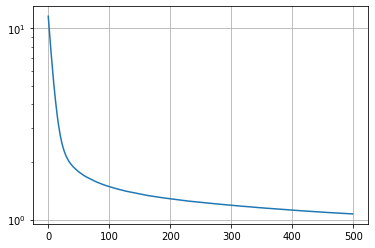

In [9]:
eval_results = model.evals_result_
l1 = eval_results["training"]["l1"]
plt.plot(l1)

#valid = eval_results["valid_1"]["l1"]
#plt.plot(valid)

#ax.set_yticks(np.linspace(100, 1000, 10))
plt.yscale('log')
plt.grid(True)

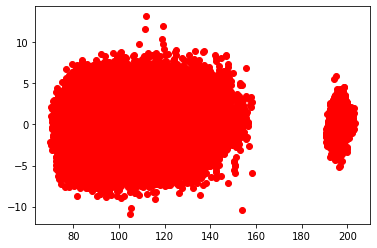

In [10]:
X_non_filter = X_train
y_non_filter = y_train
y_n_pred = model.predict(X_non_filter)
plt.plot(y_n_pred, y_non_filter - y_n_pred, 'ro')

In [11]:
err = abs(y_non_filter - y_n_pred)
_, up_err = np.percentile(err, [0,99.9])
dp = y_non_filter.to_frame()
dp['err'] = pd.Series(err)
dp.describe()

,scalar_coupling_constant,err
count,707289.000000,707289.000000
mean,94.941421,1.072371
std,18.261720,1.008195
min,66.926400,0.000011
25%,84.018600,0.345733
50%,88.202800,0.776026
75%,100.588000,1.484676
max,204.880000,13.165126


In [12]:
dpNewErr = dp[dp.err >= up_err]
dpNewErr.describe()

,scalar_coupling_constant,err
count,708.000000,708.000000
mean,106.044973,7.140841
std,19.478010,0.717390
min,67.273000,6.493464
25%,91.330225,6.680428
50%,103.948500,6.923626
75%,120.334500,7.348809
max,162.463000,13.165126


In [13]:
if dpOldErr is None:
    dfErr = dpNewErr
else:
    dfErr = pd.concat([dpOldErr,dpNewErr])
dfErr.to_csv(f'{Config.INPUT_XY_FILTER}/{coupling_type}.csv')

In [14]:
dpOldErr.describe()

,scalar_coupling_constant,err
count,2127.000000,2127.000000
mean,106.525607,8.320928
std,19.722742,2.090087
min,66.600800,6.740349
25%,92.163150,7.314259
50%,104.362000,7.853317
75%,119.481500,8.586352
max,171.220000,51.115577
